In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import vaex
import gizmo_analysis as ga
import sys
sys.path.append('../mock')
import allvariables
import beta
import getMasks
import getPhotometric
import getConversions
import getPlots
sys.path.append('../visualization')
import mollweide_plotting as pl
import nba
from astropy import units as u
from IPython.display import Image

In [2]:
# # Set the parameters
# plt.rcParams.update({
#     'axes.titlesize': 24,
#     'axes.labelsize': 20,
#     'lines.linewidth': 3,
#     'lines.markersize': 5,
#     'xtick.labelsize': 16,
#     'ytick.labelsize': 16,
# #     'text.usetex': True,
#     'axes.formatter.use_mathtext': False,
#     'xtick.minor.visible': True,
#     'ytick.minor.visible': True,
#     'xtick.top': True,
#     'xtick.bottom': True,
#     'xtick.minor.bottom': True,
#     'ytick.right': True,
#     'ytick.minor.right': True,
#     'xtick.major.size': 6,
#     'xtick.minor.size': 4,
#     'ytick.major.size': 6,
#     'ytick.minor.size': 4,
#     'xtick.major.width': 1.1,
#     'xtick.minor.width': 0.8,
#     'ytick.major.width': 1.1,
#     'ytick.minor.width': 0.8,
#     'xtick.direction': 'in',
#     'ytick.direction': 'in',
#     'figure.figsize': [6.0, 4.2]
# })

## Access Mock Parameters

In [3]:
# Get the parameters from the config file
params = allvariables.getparamsnotebook()

# Define parameter names
param_names = [
        "snap", "sim", "sim_dir", "sat_id_dir", "rmin", "rmax", "sat_mask", "ananke_name", 
        "photo_sys", "cmd_magnames", "app_mag_lim_lo", "app_mag_lim_hi", 
        "abs_mag_lim_lo", "abs_mag_lim_hi", "ananke_r_max", "fsample"
]

# Initialize parameter dictionary
params_dict = {}

# Assign values to parameters and declare them locally
for param_name, param_value in zip(param_names, params):
    params_dict[param_name] = param_value
    locals()[param_name] = param_value

## Access Ananke Data

In [4]:
# Get the current working directory
current_dir = os.getcwd()

# Go back one directory (to 'src') and then to 'mock'
ananke_file_path = os.path.join(current_dir, "..", "mock", "survey.m12b_385.h5")
ananke_sat_file_path = os.path.join(current_dir, "..", "mock", "survey.m12b_385_sat.h5")
print(f"\nOpening data from: \n{ananke_file_path} \n{ananke_sat_file_path}")

# Check if the file exists
if os.path.exists(ananke_file_path):
    # Proceed with opening the file
    survey = vaex.open(ananke_file_path)
else:
    print(f"{ananke_file_path} file does not exist.")
    
# Check if the file exists
if os.path.exists(ananke_sat_file_path):
    # Proceed with opening the file
    survey_sat = vaex.open(ananke_sat_file_path)
else:
    print(f"{ananke_sat_file_path} file does not exist.")


Opening data from: 
/home/jovyan/home/rubin_mw_mocks/src/analysis/../mock/survey.m12b_385.h5 
/home/jovyan/home/rubin_mw_mocks/src/analysis/../mock/survey.m12b_385_sat.h5


In [5]:
# Print all the columns
column_names = survey.column_names
print(column_names)

['age', 'alpha', 'calcium', 'carbon', 'dec', 'dform', 'dmod', 'feh', 'glat', 'glon', 'grav', 'helium', 'lsst_gmag', 'lsst_gmag_Err', 'lsst_gmag_Intrinsic', 'lsst_gmag_Sig', 'lsst_imag', 'lsst_imag_Err', 'lsst_imag_Intrinsic', 'lsst_imag_Sig', 'lsst_rmag', 'lsst_rmag_Err', 'lsst_rmag_Intrinsic', 'lsst_rmag_Sig', 'lsst_umag', 'lsst_umag_Err', 'lsst_umag_Intrinsic', 'lsst_umag_Sig', 'lsst_ymag', 'lsst_ymag_Err', 'lsst_ymag_Intrinsic', 'lsst_ymag_Sig', 'lsst_zmag', 'lsst_zmag_Err', 'lsst_zmag_Intrinsic', 'lsst_zmag_Sig', 'lum', 'mact', 'magnesium', 'mtip', 'mub', 'mudec', 'mul', 'mura', 'neon', 'nitrogen', 'oxygen', 'parentid', 'partid', 'pi', 'px', 'py', 'pz', 'ra', 'rad', 'silicon', 'smass', 'sulphur', 'teff', 'vr', 'vx', 'vy', 'vz']


### Apparent Magnitude

In [6]:
# Extract apparent magnitudes without satellite
app_g_mag_sat = survey_sat.lsst_gmag.to_numpy()
app_r_mag_sat = survey_sat.lsst_rmag.to_numpy()
app_i_mag_sat = survey_sat.lsst_imag.to_numpy()
app_u_mag_sat = survey_sat.lsst_umag.to_numpy()
app_y_mag_sat = survey_sat.lsst_ymag.to_numpy()
app_z_mag_sat = survey_sat.lsst_zmag.to_numpy()

In [7]:
# Declare min and max values
mag_min = app_mag_lim_lo
mag_max = app_mag_lim_hi

# Create a combined boolean mask (a single mask is used to maintain consistent shape)
mask = ((app_g_mag_sat >= mag_min) & (app_g_mag_sat <= mag_max) & 
        (app_r_mag_sat >= mag_min) & (app_r_mag_sat <= mag_max) &
        (app_i_mag_sat >= mag_min) & (app_i_mag_sat <= mag_max) &
        (app_u_mag_sat >= mag_min) & (app_u_mag_sat <= mag_max) &
        (app_y_mag_sat >= mag_min) & (app_y_mag_sat <= mag_max) &
        (app_z_mag_sat >= mag_min) & (app_z_mag_sat <= mag_max))

# Apply masks to filter out values outside the set limits
app_g_mag_sat_mask = app_g_mag_sat[mask]
app_r_mag_sat_mask = app_r_mag_sat[mask]
app_i_mag_sat_mask = app_i_mag_sat[mask]
app_u_mag_sat_mask = app_u_mag_sat[mask]
app_y_mag_sat_mask = app_y_mag_sat[mask]
app_z_mag_sat_mask = app_z_mag_sat[mask]

### Absolute Magnitude

In [8]:
# Extract the radial distance as parsecs
rad_distance_sat = survey_sat.rad.to_numpy() * 1000

In [9]:
# Apply mask to distance
rad_distance_sat_mask = rad_distance_sat[mask]

In [10]:
# Extract absolute magnitudes without satellite
g_mag_sat = getConversions.app2abs(app_g_mag_sat, rad_distance_sat)
r_mag_sat = getConversions.app2abs(app_r_mag_sat, rad_distance_sat)
i_mag_sat = getConversions.app2abs(app_i_mag_sat, rad_distance_sat)
u_mag_sat = getConversions.app2abs(app_u_mag_sat, rad_distance_sat)
y_mag_sat = getConversions.app2abs(app_y_mag_sat, rad_distance_sat)
z_mag_sat = getConversions.app2abs(app_z_mag_sat, rad_distance_sat)

In [11]:
# Extract absolute magnitudes without satellite and with the mask
g_mag_sat_mask = getConversions.app2abs(app_g_mag_sat_mask, rad_distance_sat_mask)
r_mag_sat_mask = getConversions.app2abs(app_r_mag_sat_mask, rad_distance_sat_mask)
i_mag_sat_mask = getConversions.app2abs(app_i_mag_sat_mask, rad_distance_sat_mask)
u_mag_sat_mask = getConversions.app2abs(app_u_mag_sat_mask, rad_distance_sat_mask)
y_mag_sat_mask = getConversions.app2abs(app_y_mag_sat_mask, rad_distance_sat_mask)
z_mag_sat_mask = getConversions.app2abs(app_z_mag_sat_mask, rad_distance_sat_mask)

## Adding Photometric Error

In [12]:
# Add the sigma value to each apparent magnitude
app_g_mag_sat_err = app_g_mag_sat + getPhotometric.getSigmaVisit('g', app_g_mag_sat)
app_r_mag_sat_err = app_r_mag_sat + getPhotometric.getSigmaVisit('r', app_r_mag_sat)
app_i_mag_sat_err = app_i_mag_sat + getPhotometric.getSigmaVisit('i', app_i_mag_sat)
app_u_mag_sat_err = app_u_mag_sat + getPhotometric.getSigmaVisit('u', app_u_mag_sat)
app_y_mag_sat_err = app_y_mag_sat + getPhotometric.getSigmaVisit('y', app_y_mag_sat)
app_z_mag_sat_err = app_z_mag_sat + getPhotometric.getSigmaVisit('z', app_z_mag_sat)

In [13]:
# Add the sigma value to each apparent magnitude
app_g_mag_sat_mask_err = app_g_mag_sat_mask + getPhotometric.getSigmaVisit('g', app_g_mag_sat_mask)
app_r_mag_sat_mask_err = app_r_mag_sat_mask + getPhotometric.getSigmaVisit('r', app_r_mag_sat_mask)
app_i_mag_sat_mask_err = app_i_mag_sat_mask + getPhotometric.getSigmaVisit('i', app_i_mag_sat_mask)
app_u_mag_sat_mask_err = app_u_mag_sat_mask + getPhotometric.getSigmaVisit('u', app_u_mag_sat_mask)
app_y_mag_sat_mask_err = app_y_mag_sat_mask + getPhotometric.getSigmaVisit('y', app_y_mag_sat_mask)
app_z_mag_sat_mask_err = app_z_mag_sat_mask + getPhotometric.getSigmaVisit('z', app_z_mag_sat_mask)

In [14]:
# Extract just the error of g mag for testing
error_array = getPhotometric.getSigmaRand('g', app_g_mag_sat_mask)

In [15]:
print(error_array)
print(min(error_array))
print(max(error_array))

[0.03691901 0.01211195 0.36468884 ... 0.19102468 0.1698922  0.17439333]
0.0008319475
1.0888652


Here I am calculating absolute magnitude from apparent magnitude with errors. I could also calculate the error using getPhotometric error itself, but I'm not sure with method is correct. 

In [16]:
# Extract absolute magnitudes without satellite and with error
g_mag_sat_err = getConversions.app2abs(app_g_mag_sat_err, rad_distance_sat)
r_mag_sat_err = getConversions.app2abs(app_r_mag_sat_err, rad_distance_sat)
i_mag_sat_err = getConversions.app2abs(app_i_mag_sat_err, rad_distance_sat)
u_mag_sat_err = getConversions.app2abs(app_u_mag_sat_err, rad_distance_sat)
y_mag_sat_err = getConversions.app2abs(app_y_mag_sat_err, rad_distance_sat)
z_mag_sat_err = getConversions.app2abs(app_z_mag_sat_err, rad_distance_sat)

In [17]:
# Extract absolute magnitudes without satellite and with error
g_mag_sat_mask_err = getConversions.app2abs(app_g_mag_sat_mask_err, rad_distance_sat_mask)
r_mag_sat_mask_err = getConversions.app2abs(app_r_mag_sat_mask_err, rad_distance_sat_mask)
i_mag_sat_mask_err = getConversions.app2abs(app_i_mag_sat_mask_err, rad_distance_sat_mask)
u_mag_sat_mask_err = getConversions.app2abs(app_u_mag_sat_mask_err, rad_distance_sat_mask)
y_mag_sat_mask_err = getConversions.app2abs(app_y_mag_sat_mask_err, rad_distance_sat_mask)
z_mag_sat_mask_err = getConversions.app2abs(app_z_mag_sat_mask_err, rad_distance_sat_mask)

## Color Magnitude Diagram

In [18]:
# Calculate g - r
g_minus_r_sat_mask = app_g_mag_sat_mask - app_r_mag_sat_mask

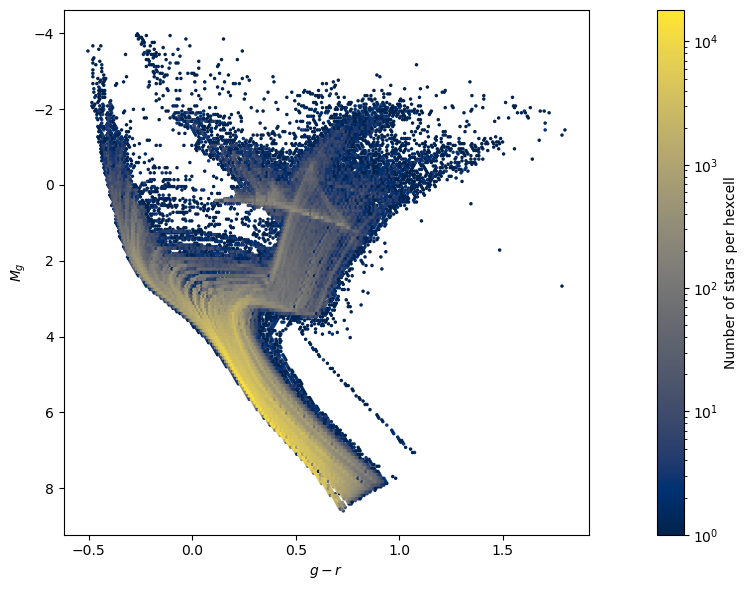

In [19]:
# Create color magnitude diagram
getPlots.colormagplot(g_minus_r_sat_mask, g_mag_sat_mask)

In [20]:
# Calculate g - r with error
g_minus_r_sat_mask_err = app_g_mag_sat_mask_err - app_r_mag_sat_mask_err

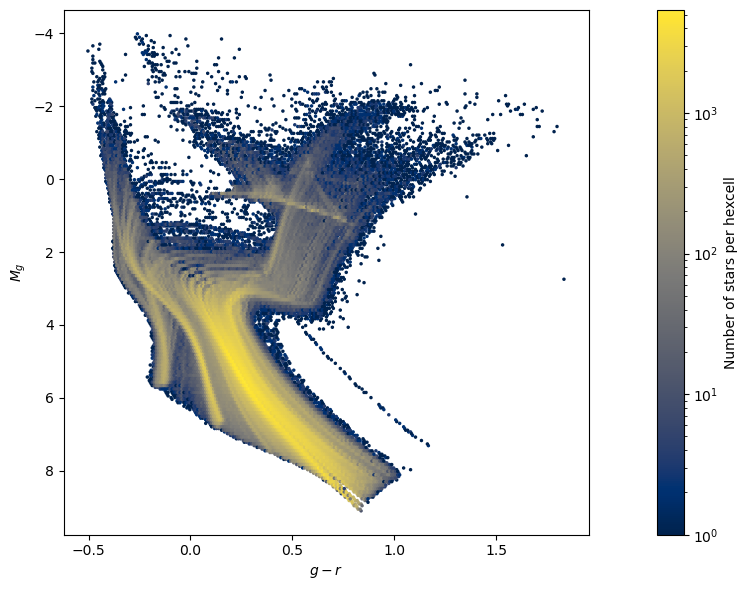

In [21]:
# Create color magnitude diagram with error valeus
getPlots.colormagplot(g_minus_r_sat_mask_err, g_mag_sat_mask_err)

## Density Profile

In [22]:
# Extract distance
anankeRadialSat = survey_sat.rad.to_numpy()
anankeRadialSatErr = anankeRadialSat[mask]

In [23]:
# Calculate density parameters
anankeEdgesSat, anankeDensitySat = getPlots.densityParams(anankeRadialSat, bins=200, rmin=rmin, rmax=rmax)
anankeEdgesSatErr, anankeDensitySatErr = getPlots.densityParams(anankeRadialSatErr, bins=200, rmin=rmin, rmax=rmax)

In [24]:
# Apply interpolation to each dataset
ananke_x_interp_sat, ananke_y_interp_sat = getPlots.interpolate_density(anankeEdgesSat[:-1], anankeDensitySat)
ananke_x_interp_sat_err, ananke_y_interp_sat_err = getPlots.interpolate_density(anankeEdgesSatErr[:-1], anankeDensitySatErr)

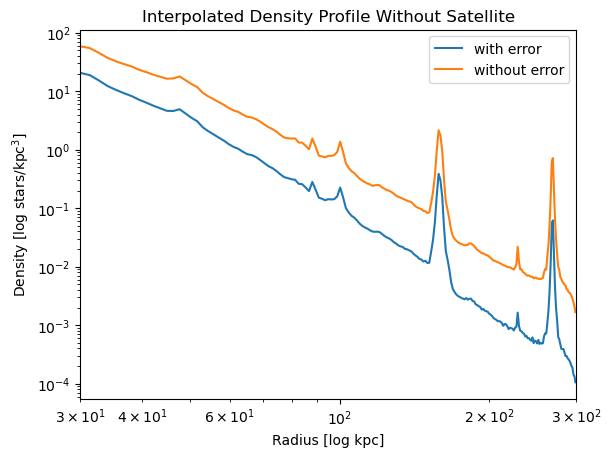

In [25]:
# Plot the density profile with interpolated values
fig, ax = plt.subplots()
ax.loglog(ananke_x_interp_sat_err, ananke_y_interp_sat_err, label='with error')
ax.loglog(ananke_x_interp_sat, ananke_y_interp_sat, label='without error')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Interpolated Density Profile Without Satellite')
plt.show()

In [26]:
# Normalize the plot above
ananke_y_interp_sat_norm = getPlots.normalize_data(ananke_y_interp_sat)
ananke_y_interp_sat_err_norm = getPlots.normalize_data(ananke_y_interp_sat_err)

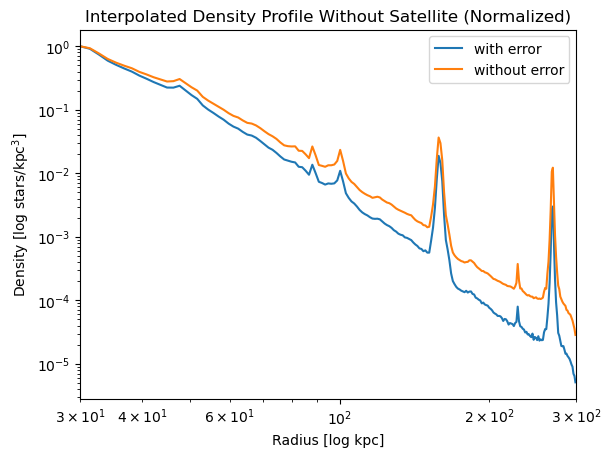

In [27]:
# Plot the density profile with interpolated values
fig, ax = plt.subplots()
ax.loglog(ananke_x_interp_sat_err, ananke_y_interp_sat_err_norm, label='with error')
ax.loglog(ananke_x_interp_sat, ananke_y_interp_sat_norm, label='without error')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Interpolated Density Profile Without Satellite (Normalized)')
plt.show()

## Proper Motion Plots

In [28]:
# Extract proper motions
mub = survey_sat.mub.to_numpy()      # glat 
mul = survey_sat.mul.to_numpy()      # glon
mura = survey_sat.mura.to_numpy()    # ra
mudec = survey_sat.mudec.to_numpy()  # dec

In [29]:
# Extract pos and vel
anankePosSat = np.stack((survey_sat.px.to_numpy(), survey_sat.py.to_numpy(), survey_sat.pz.to_numpy())).T
anankeVelSat = np.stack((survey_sat.vx.to_numpy(), survey_sat.vy.to_numpy(), survey_sat.vz.to_numpy())).T

In [30]:
# Apply kinematics 
f = 1* (u.km/u.s).to(u.kpc/u.Gyr)
kinematics1_ananke_sat = nba.kinematics.Kinematics(anankePosSat, anankeVelSat)
pos_galactic_ananke_sat = kinematics1_ananke_sat.pos_cartesian_to_galactic()
vel_galactic_ananke_sat = kinematics1_ananke_sat.vel_cartesian_to_galactic()

In [31]:
# NOTE: This did not run due to excessive memory usage
# fig_ananke_sat_proper = f"ananke_mollweide_sat_proper.png"
# pl.mollweide_projection(pos_galactic_ananke_sat[0]*180/np.pi, pos_galactic_ananke_sat[1]*180/np.pi, mub, mul, 
#                         sim_dir=sim_dir, bmin=0, bmax=2000, nside=40, smooth=5, figname=fig_ananke_sat_proper)

In [32]:
# Image(fig_ananke_sat_proper)

In [33]:
# Check number of stars
# Try subsample

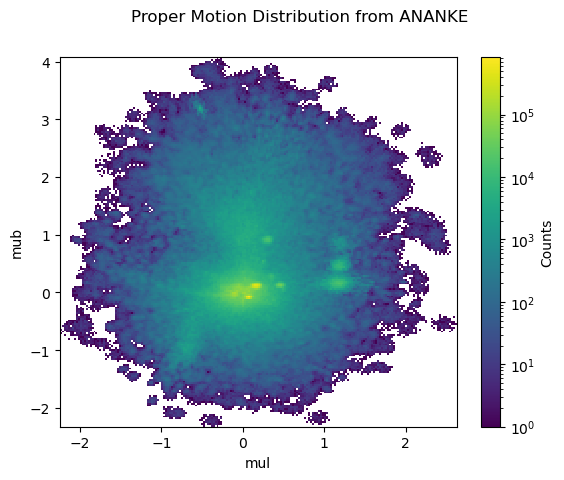

In [34]:
import matplotlib

# Declare number of bins
bins = 200

# Create the figure
fig = plt.figure()
ax = plt.gca()

# Use 2-D histogram
counts, xedges, yedges, im = ax.hist2d(
    mul,
    mub,
    bins = bins,
    norm = matplotlib.colors.LogNorm(),
)

# Add labels, aspect ration, and title
ax.set_xlabel( 'mul' )
ax.set_ylabel( 'mub' )
#ax.set_aspect( 'equal' )
fig.suptitle("Proper Motion Distribution from ANANKE");

# Add color bar
cbar = plt.colorbar(im)
cbar.set_label('Counts')

plt.show()

## Population Selections with and without Errors

In [35]:
# Define the bin edges
bins = 100

In [36]:
# Create a binned radius array 
dr = np.linspace(0, rmax, bins)

In [37]:
# Extract radial distance without satellite
anankeRadialSat = survey_sat.rad.to_numpy()

In [38]:
# Extract metalicity without satellite
feh_sat = survey_sat.feh.to_numpy()

### Without Errors

In [39]:
# Calculate u - g 
u_minus_g_sat = app_u_mag_sat - app_g_mag_sat

# Calculate g - r
g_minus_r_sat = app_g_mag_sat - app_r_mag_sat

### With Errors

In [40]:
# Calculate u - g
u_minus_g_sat_err = app_u_mag_sat_err - app_g_mag_sat_err

# Calculate g - r
g_minus_r_sat_err = app_g_mag_sat_err - app_r_mag_sat_err

### 1. BHB

### Without Errors

In [41]:
# Get BHB mask
bhb_mask_sat = getMasks.getBHB(g_minus_r_sat, u_minus_g_sat, g_mag_sat)

# Calculate density parameters
bhbEdgesSat, bhbDensitySat = getPlots.densityParams(anankeRadialSat[bhb_mask_sat], bins, rmin, rmax)

# Call the velocity dispersion function from beta.py
bhb_vr_disp_r_sat, bhb_vtheta_disp_r_sat, bhb_vphi_disp_r_sat = beta.velocity_dispersions_r(anankePosSat[bhb_mask_sat], anankeVelSat[bhb_mask_sat], bins, rmax)

# Calculate radial velocity dispersion 
bhb_v_disp_sat = (bhb_vtheta_disp_r_sat**2 + bhb_vphi_disp_r_sat**2)**0.5

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### With Errors

In [42]:
# Get BHB mask
bhb_mask_sat_err = getMasks.getBHB(g_minus_r_sat_err, u_minus_g_sat_err, g_mag_sat_err)

# Calculate density parameters
bhbEdgesSatErr, bhbDensitySatErr = getPlots.densityParams(anankeRadialSat[bhb_mask_sat_err], bins, rmin, rmax)

# Call the velocity dispersion function from beta.py
bhb_vr_disp_r_sat_err, bhb_vtheta_disp_r_sat_err, bhb_vphi_disp_r_sat_err = beta.velocity_dispersions_r(anankePosSat[bhb_mask_sat_err], anankeVelSat[bhb_mask_sat_err], bins, rmax)

# Calculate radial velocity dispersion 
bhb_v_disp_sat_err = (bhb_vtheta_disp_r_sat_err**2 + bhb_vphi_disp_r_sat_err**2)**0.5

### 2. K-Giant

### Without Errors

In [43]:
# Get K-Giant mask without satellite
kgiant_mask_sat = getMasks.getKGiant(g_minus_r_sat, u_minus_g_sat, g_mag_sat, feh_sat)

# Calculate density parameters
kgiantEdgesSat, kgiantDensitySat = getPlots.densityParams(anankeRadialSat[kgiant_mask_sat], bins, rmin, rmax)

# Call the velocity dispersion function from beta.py
kgiant_vr_disp_r_sat, kgiant_vtheta_disp_r_sat, kgiant_vphi_disp_r_sat = beta.velocity_dispersions_r(anankePosSat[kgiant_mask_sat], anankeVelSat[kgiant_mask_sat], bins, rmax)

# Calculate radial velocity dispersion 
kgiant_v_disp_sat = (kgiant_vtheta_disp_r_sat**2 + kgiant_vphi_disp_r_sat**2)**0.5

### With Errors

In [44]:
# Get K-Giant mask without satellite
kgiant_mask_sat_err = getMasks.getKGiant(g_minus_r_sat_err, u_minus_g_sat_err, g_mag_sat_err, feh_sat)

# Calculate density parameters
kgiantEdgesSatErr, kgiantDensitySatErr = getPlots.densityParams(anankeRadialSat[kgiant_mask_sat_err], bins, rmin, rmax)

# Call the velocity dispersion function from beta.py
kgiant_vr_disp_r_sat_err, kgiant_vtheta_disp_r_sat_err, kgiant_vphi_disp_r_sat_err = beta.velocity_dispersions_r(anankePosSat[kgiant_mask_sat_err], anankeVelSat[kgiant_mask_sat_err], bins, rmax)

# Calculate radial velocity dispersion 
kgiant_v_disp_sat_err = (kgiant_vtheta_disp_r_sat_err**2 + kgiant_vphi_disp_r_sat_err**2)**0.5

### 3. MSTO

### Without Errors

In [45]:
# Create MSTO mask without satellite
msto_mask_sat = getMasks.getMSTO(g_minus_r_sat, g_mag_sat)

# Calculate density parameters
mstoEdgesSat, mstoDensitySat = getPlots.densityParams(anankeRadialSat[msto_mask_sat], bins, rmin, rmax)

# Call the velocity dispersion function from beta.py
msto_vr_disp_r_sat, msto_vtheta_disp_r_sat, msto_vphi_disp_r_sat = beta.velocity_dispersions_r(anankePosSat[msto_mask_sat], anankeVelSat[msto_mask_sat], bins, rmax)

# Calculate radial velocity dispersion 
msto_v_disp_sat = (msto_vtheta_disp_r_sat**2 + msto_vphi_disp_r_sat**2)**0.5

### With Errors

In [46]:
# Create MSTO mask without satellite
msto_mask_sat_err = getMasks.getMSTO(g_minus_r_sat_err, g_mag_sat_err)

# Calculate density parameters
mstoEdgesSatErr, mstoDensitySatErr = getPlots.densityParams(anankeRadialSat[msto_mask_sat_err], bins, rmin, rmax)

# Call the velocity dispersion function from beta.py
msto_vr_disp_r_sat_err, msto_vtheta_disp_r_sat_err, msto_vphi_disp_r_sat_err = beta.velocity_dispersions_r(anankePosSat[msto_mask_sat_err], anankeVelSat[msto_mask_sat_err], bins, rmax)

# Calculate radial velocity dispersion 
msto_v_disp_sat_err = (msto_vtheta_disp_r_sat_err**2 + msto_vphi_disp_r_sat_err**2)**0.5

## Population Plots

In [53]:
# Apply interpolation to each dataset
msto_x_interp_sat, msto_y_interp_sat = getPlots.interpolate_density(mstoEdgesSat[:-1], mstoDensitySat)
kgiant_x_interp_sat, kgiant_y_interp_sat = getPlots.interpolate_density(kgiantEdgesSat[:-1], kgiantDensitySat)
bhb_x_interp_sat, bhb_y_interp_sat = getPlots.interpolate_density(bhbEdgesSat[:-1], bhbDensitySat)

In [54]:
# Apply interpolation to each dataset
msto_x_interp_sat_err, msto_y_interp_sat_err = getPlots.interpolate_density(mstoEdgesSatErr[:-1], mstoDensitySatErr)
kgiant_x_interp_sat_err, kgiant_y_interp_sat_err = getPlots.interpolate_density(kgiantEdgesSatErr[:-1], kgiantDensitySatErr)
bhb_x_interp_sat_err, bhb_y_interp_sat_err = getPlots.interpolate_density(bhbEdgesSatErr[:-1], bhbDensitySatErr)

In [55]:
# Apply interpolation to each dataset for velocity radial dispersion
msto_r_interp_sat, msto_vr_disp_interp_sat = getPlots.interpolate_velocity(dr[1:], msto_vr_disp_r_sat)
kgiant_r_interp_sat, kgiant_vr_disp_interp_sat = getPlots.interpolate_velocity(dr[1:], kgiant_vr_disp_r_sat)
bhb_r_interp_sat, bhb_vr_disp_interp_sat = getPlots.interpolate_velocity(dr[1:], bhb_vr_disp_r_sat)

In [56]:
# Apply interpolation to each dataset for velocity radial dispersion
msto_r_interp_sat_err, msto_vr_disp_interp_sat_err = getPlots.interpolate_velocity(dr[1:], msto_vr_disp_r_sat_err)
kgiant_r_interp_sat_err, kgiant_vr_disp_interp_sat_err = getPlots.interpolate_velocity(dr[1:], kgiant_vr_disp_r_sat_err)
bhb_r_interp_sat_err, bhb_vr_disp_interp_sat_err = getPlots.interpolate_velocity(dr[1:], bhb_vr_disp_r_sat_err)

In [57]:
# Apply interpolation to each dataset for velocity tangential dispersion
msto_r_interp_sat, msto_v_disp_interp_sat = getPlots.interpolate_velocity(dr[1:], msto_v_disp_sat)
kgiant_r_interp_sat, kgiant_v_disp_interp_sat = getPlots.interpolate_velocity(dr[1:], kgiant_v_disp_sat)
bhb_r_interp_sat, bhb_v_disp_interp_sat = getPlots.interpolate_velocity(dr[1:], bhb_v_disp_sat)

In [59]:
# Apply interpolation to each dataset for velocity tangential dispersion
msto_r_interp_sat_err, msto_v_disp_interp_sat_err = getPlots.interpolate_velocity(dr[1:], msto_v_disp_sat_err)
kgiant_r_interp_sat_err, kgiant_v_disp_interp_sat_err = getPlots.interpolate_velocity(dr[1:], kgiant_v_disp_sat_err)
bhb_r_interp_sat_err, bhb_v_disp_interp_sat_err = getPlots.interpolate_velocity(dr[1:], bhb_v_disp_sat_err)

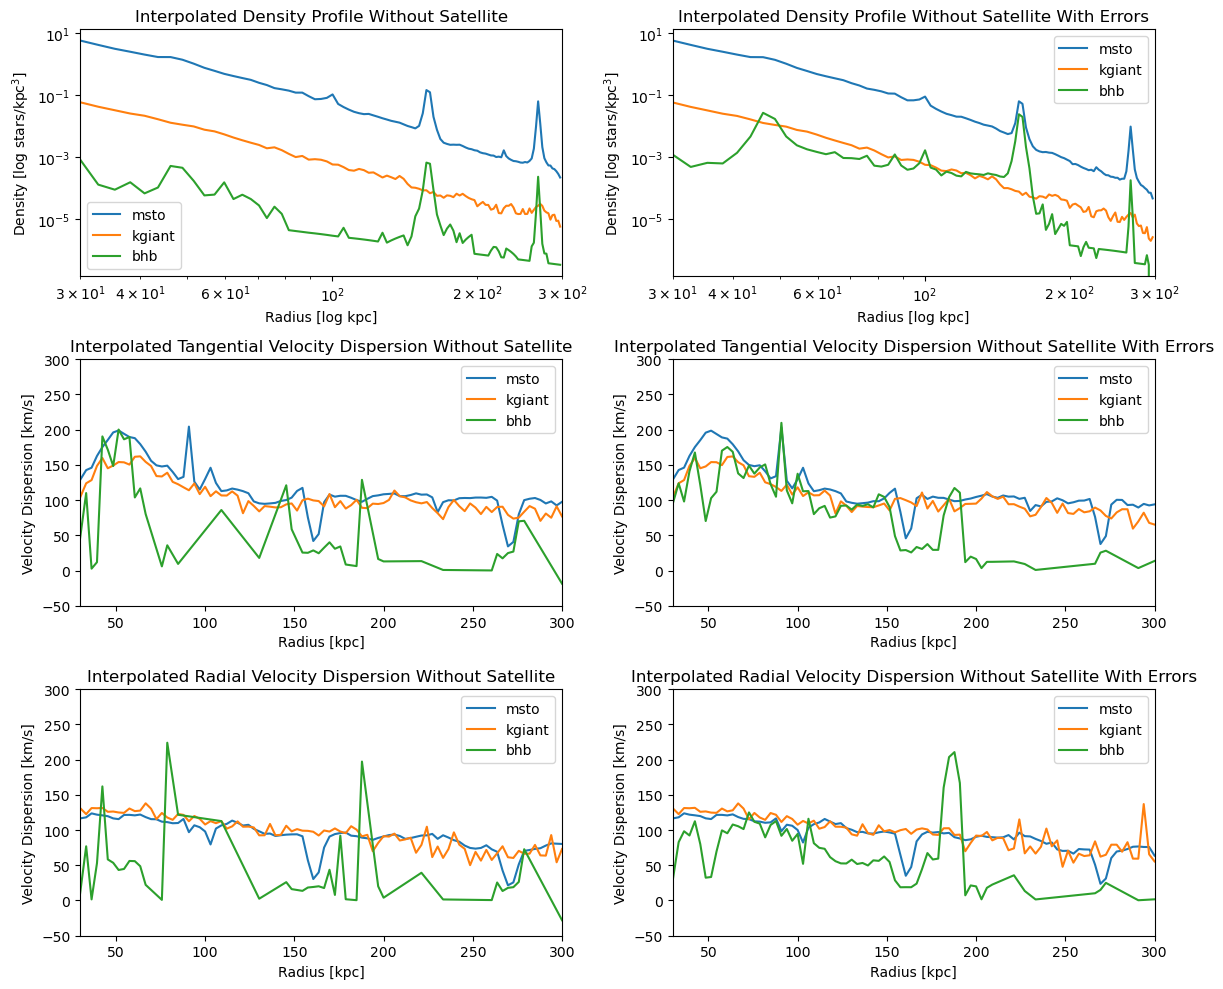

In [60]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10)) 

axes[0, 0].loglog(msto_x_interp_sat, msto_y_interp_sat, label='msto')
axes[0, 0].loglog(kgiant_x_interp_sat, kgiant_y_interp_sat, label='kgiant')
axes[0, 0].loglog(bhb_x_interp_sat, bhb_y_interp_sat, label='bhb')
axes[0, 0].set_xlabel('Radius [log kpc]')
axes[0, 0].set_ylabel('Density [log stars/kpc$^3$]')
axes[0, 0].set_xlim(rmin, rmax)
axes[0, 0].set_ylim()
axes[0, 0].legend()
axes[0, 0].set_title('Interpolated Density Profile Without Satellite')

axes[0, 1].loglog(msto_x_interp_sat_err, msto_y_interp_sat_err, label='msto')
axes[0, 1].loglog(kgiant_x_interp_sat_err, kgiant_y_interp_sat_err, label='kgiant')
axes[0, 1].loglog(bhb_x_interp_sat_err, bhb_y_interp_sat_err, label='bhb')
axes[0, 1].set_xlabel('Radius [log kpc]')
axes[0, 1].set_ylabel('Density [log stars/kpc$^3$]')
axes[0, 1].set_xlim(rmin, rmax)
axes[0, 1].set_ylim()
axes[0, 1].legend()
axes[0, 1].set_title('Interpolated Density Profile Without Satellite With Errors')

axes[1, 0].plot(msto_r_interp_sat, msto_v_disp_interp_sat, label='msto')
axes[1, 0].plot(kgiant_r_interp_sat, kgiant_v_disp_interp_sat, label='kgiant')
axes[1, 0].plot(bhb_r_interp_sat, bhb_v_disp_interp_sat, label='bhb')
axes[1, 0].set_xlabel('Radius [kpc]')
axes[1, 0].set_ylabel('Velocity Dispersion [km/s]')
axes[1, 0].set_xlim(rmin, rmax)
axes[1, 0].set_ylim(-50, 300)
axes[1, 0].legend()
axes[1, 0].set_title('Interpolated Tangential Velocity Dispersion Without Satellite')

axes[1, 1].plot(msto_r_interp_sat_err, msto_v_disp_interp_sat_err, label='msto')
axes[1, 1].plot(kgiant_r_interp_sat_err, kgiant_v_disp_interp_sat_err, label='kgiant')
axes[1, 1].plot(bhb_r_interp_sat_err, bhb_v_disp_interp_sat_err, label='bhb')
axes[1, 1].set_xlabel('Radius [kpc]')
axes[1, 1].set_ylabel('Velocity Dispersion [km/s]')
axes[1, 1].set_xlim(rmin, rmax)
axes[1, 1].set_ylim(-50, 300)
axes[1, 1].legend()
axes[1, 1].set_title('Interpolated Tangential Velocity Dispersion Without Satellite With Errors')

axes[2, 0].plot(msto_r_interp_sat, msto_vr_disp_interp_sat, label='msto')
axes[2, 0].plot(kgiant_r_interp_sat, kgiant_vr_disp_interp_sat, label='kgiant')
axes[2, 0].plot(bhb_r_interp_sat, bhb_vr_disp_interp_sat, label='bhb')
axes[2, 0].set_xlabel('Radius [kpc]')
axes[2, 0].set_ylabel('Velocity Dispersion [km/s]')
axes[2, 0].set_xlim(rmin, rmax)
axes[2, 0].set_ylim(-50, 300)
axes[2, 0].legend()
axes[2, 0].set_title('Interpolated Radial Velocity Dispersion Without Satellite')

axes[2, 1].plot(msto_r_interp_sat_err, msto_vr_disp_interp_sat_err, label='msto')
axes[2, 1].plot(kgiant_r_interp_sat_err, kgiant_vr_disp_interp_sat_err, label='kgiant')
axes[2, 1].plot(bhb_r_interp_sat_err, bhb_vr_disp_interp_sat_err, label='bhb')
axes[2, 1].set_xlabel('Radius [kpc]')
axes[2, 1].set_ylabel('Velocity Dispersion [km/s]')
axes[2, 1].set_xlim(rmin, rmax)
axes[2, 1].set_ylim(-50, 300)
axes[2, 1].legend()
axes[2, 1].set_title('Interpolated Radial Velocity Dispersion Without Satellite With Errors')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()